## dataset link 

https://www.kaggle.com/datasets/austinreese/craigslist-carstrucks-data

https://www.kaggle.com/datasets/sukritchatterjee/used-cars-dataset-cardekho

In [8]:
import pandas as pd
from pathlib import Path

CACHE = "dataset/autovalu_mvp.parquet"
RAW = "dataset/vehicles.csv"


In [9]:
# Step 2 — Load dataset with caching (final cell)


if Path(CACHE).exists():
    # Fast path: load compact dataset
    df = pd.read_parquet(CACHE, engine="pyarrow")
    print("Loaded compact dataset:", df.shape)
else:
    # Slow path: load raw CSV and reduce it, then save
    df_raw = pd.read_csv(RAW, low_memory=False, on_bad_lines="skip")

    # Drop useless columns
    cols_to_drop = ["id","url","region_url","VIN","image_url","description",
                    "county","lat","long","posting_date"]
    df_reduced = df_raw.drop(columns=[c for c in cols_to_drop if c in df_raw.columns], errors="ignore").copy()

    # Convert to categories
    cat_cols = ["manufacturer","model","condition","cylinders","fuel","title_status",
                "transmission","drive","size","type","paint_color","state","region"]
    for c in cat_cols:
        if c in df_reduced.columns and df_reduced[c].dtype == "object":
            df_reduced[c] = df_reduced[c].astype("category")

    # Numeric compression
    if "year" in df_reduced.columns:
        df_reduced["year"] = pd.to_numeric(df_reduced["year"], errors="coerce").astype("Int16")
    if "price" in df_reduced.columns:
        df_reduced["price"] = pd.to_numeric(df_reduced["price"], errors="coerce", downcast="integer")
    if "odometer" in df_reduced.columns:
        df_reduced["odometer"] = pd.to_numeric(df_reduced["odometer"], errors="coerce", downcast="float")

    # Save compact version
    df_reduced.to_parquet(CACHE, engine="pyarrow", compression="zstd", index=False)
    df = df_reduced
    print("Built and cached compact dataset:", df.shape)


Loaded compact dataset: (426880, 16)


DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   region        426880 non-null  category
 1   price         426880 non-null  int64   
 2   year          425675 non-null  Int16   
 3   manufacturer  409234 non-null  category
 4   model         421603 non-null  category
 5   condition     252776 non-null  category
 6   cylinders     249202 non-null  category
 7   fuel          423867 non-null  category
 8   odometer      422480 non-null  float32 
 9   title_status  418638 non-null  category
 10  transmission  424324 non-null  category
 11  drive         296313 non-null  category
 12  size          120519 non-null  category
 13  type          334022 non-null  category
 14  paint_color   296677 non-null  category
 15  state         426880 non-null  category
dtypes: Int16(1), category(13), float32(1), int64(1)
memory usa

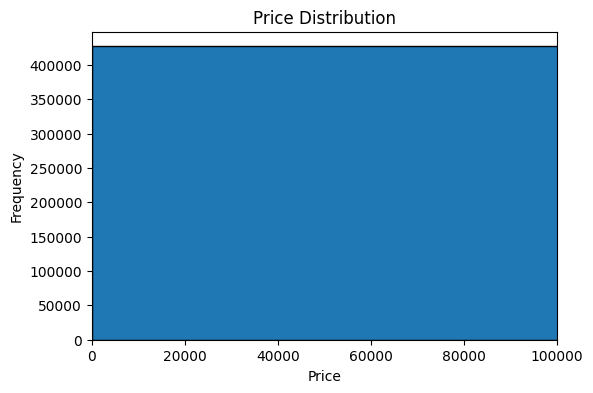

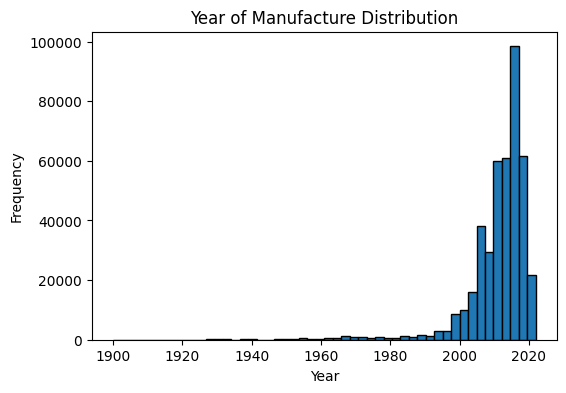

In [10]:
# Step 4 — Basic EDA (Exploratory Data Analysis)

import matplotlib.pyplot as plt

# 1. General info
print("DataFrame Info:")
print(df.info())
print("\nSummary statistics (numeric):")
print(df.describe())

# 2. Missing values summary (top 10)
missing = df.isna().sum().sort_values(ascending=False)
missing_percent = (missing / len(df) * 100).round(2)
print("\nMissing Values (Top 10):")
print(pd.DataFrame({"MissingCount": missing, "MissingPercent": missing_percent}).head(10))

# 3. Price distribution
plt.figure(figsize=(6,4))
df["price"].plot(kind="hist", bins=100, edgecolor="black")
plt.title("Price Distribution")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.xlim(0, 100000)  # clip to focus on normal range
plt.show()

# 4. Year distribution
plt.figure(figsize=(6,4))
df["year"].dropna().astype(int).plot(kind="hist", bins=50, edgecolor="black")
plt.title("Year of Manufacture Distribution")
plt.xlabel("Year")
plt.ylabel("Frequency")
plt.show()


In [11]:
# Step 5 — Data Cleaning

import numpy as np

before = df.shape[0]

# 1. Filter price
df = df[(df["price"] >= 100) & (df["price"] <= 200000)]

# 2. Filter year
df = df[(df["year"].isna()) | ((df["year"] >= 1960) & (df["year"] <= 2025))]

# 3. Drop high-missing columns
drop_cols = ["size", "condition", "cylinders"]
df = df.drop(columns=drop_cols, errors="ignore")

after = df.shape[0]
removed = before - after
print(f"Removed rows: {removed} ({round(removed/before*100, 2)}%)")
print("Remaining shape:", df.shape)
print("Columns:", list(df.columns))


Removed rows: 38655 (9.06%)
Remaining shape: (388225, 13)
Columns: ['region', 'price', 'year', 'manufacturer', 'model', 'fuel', 'odometer', 'title_status', 'transmission', 'drive', 'type', 'paint_color', 'state']


In [12]:
# Step 6 — Feature Engineering & Train/Test Split

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. Define features and target
target = "price"
features = [col for col in df.columns if col != target]

X = df[features].copy()
y = df[target].copy()

# 2. Encode categorical columns
cat_cols = X.select_dtypes(include="category").columns
for c in cat_cols:
    X[c] = X[c].cat.codes  # converts categories to integer codes

# 3. Scale numerical columns
num_cols = ["odometer", "year"]
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

# 4. Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)
print("Features:", X_train.columns.tolist())


Train shape: (310580, 12)
Test shape: (77645, 12)
Features: ['region', 'year', 'manufacturer', 'model', 'fuel', 'odometer', 'title_status', 'transmission', 'drive', 'type', 'paint_color', 'state']


In [14]:
# Step 7 — Impute numeric NaNs and re-train linear models

from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Impute numeric columns BEFORE modeling
num_cols = ["odometer", "year"]
imputer_num = SimpleImputer(strategy="median")
X_train[num_cols] = imputer_num.fit_transform(X_train[num_cols])
X_test[num_cols] = imputer_num.transform(X_test[num_cols])

# Train Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lin = lin_reg.predict(X_test)

# Train Ridge Regression
ridge_reg = Ridge(alpha=1.0, random_state=42)
ridge_reg.fit(X_train, y_train)
y_pred_ridge = ridge_reg.predict(X_test)

# Evaluate
def evaluate(y_true, y_pred, name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{name} Results:")
    print(f"  MAE : {mae:,.2f}")
    print(f"  RMSE: {rmse:,.2f}")
    print(f"  R²  : {r2:.4f}\n")

evaluate(y_test, y_pred_lin, "Linear Regression")
evaluate(y_test, y_pred_ridge, "Ridge Regression")


Linear Regression Results:
  MAE : 9,405.26
  RMSE: 13,157.68
  R²  : 0.2384

Ridge Regression Results:
  MAE : 9,405.26
  RMSE: 13,157.68
  R²  : 0.2384

